### Section 1: Importing Necessary Libraries  

This notebook contains the implementation of a machine learning model for predicting bore measurements. The following libraries are required for data preprocessing, model training, evaluation, and visualization:

- **`pandas` & `numpy`** → Data manipulation and numerical computations.  
- **`matplotlib.pyplot`** → Visualization tools for data exploration and model performance evaluation.  
- **`sklearn`** → Machine learning utilities, including regression models, evaluation metrics, and dataset splitting.  
- **`statsmodels`** → Statistical modeling tools, specifically for time-series analysis (e.g., autocorrelation).  
- **`joblib`** → Model persistence for saving and loading trained models.  


In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf

### Section 2: Loading the Dataset  

The dataset is loaded from an Excel file into a Pandas DataFrame. This step ensures that the raw data is accessible for further preprocessing and analysis.

- The dataset is stored in a structured format, and Pandas is used to efficiently read the data.
- The `header=0` parameter ensures that the first row is interpreted as column headers.
- The file path should be updated accordingly if the dataset is relocated.


In [ ]:
"""Load the dataset from an Excel file into a Pandas DataFrame."""

file_path = (
    r"G:\College\University of Montana\Semester 4\Capstone"
    r"\MSBA-Capstone-Riley-ORorke\data\Source_Capstone_Data.xlsx"
)

df = pd.read_excel(file_path, header=0)  # Ensure headers are recognized


### Section 3: Data Cleaning  

Before proceeding with feature engineering and modeling, it is essential to clean the dataset to ensure consistency and remove irrelevant or problematic data. This step focuses on:  

- **Removing unnecessary columns** that do not contribute to predictive modeling.  
- **Ensuring correct data types** for measurement values and timestamps.  
- **Handling missing values** by filtering out rows with invalid timestamps.  
- **Detecting and removing outliers** using **Interquartile Range (IQR) filtering** to ensure that extreme values do not negatively impact the model.  

In [5]:
"""Data Cleaning: Removing unnecessary columns, converting types, 
and handling outliers using IQR filtering."""

# Drop unnecessary columns
columns_to_drop = [
    "D.[NamePostfix]", "F.[Name]", "G1.[ParameterID]", "G1.[Name]",
    "G1.[OperatorMessage]", "G2.[ParameterID]", "G2.[Name]", 
    "G2.[Description]", "G3.[ParameterID]", "G3.[Name]", 
    "G3.[OperatorMessage]", "A.[ParameterID]", "A.[EntryTimestamp]", 
    "A.[DataValue]", "A.[Description]", "B.[ParameterID]", 
    "B.[EntryTimestamp]", "B.[DataValue]", "B.[Description]", 
    "C.[ParameterID]"
]

df = df.drop(
    columns=[col for col in columns_to_drop if col in df.columns], 
    errors="ignore"
)

# Convert measurement values to numeric
df["C.[DataValue]"] = pd.to_numeric(df["C.[DataValue]"], errors="coerce")

# Convert timestamps to datetime and sort the dataset
df["C.[EntryTimestamp]"] = pd.to_datetime(
    df["C.[EntryTimestamp]"], errors="coerce"
)
df = df.dropna(subset=["C.[EntryTimestamp]"]).sort_values(
    by="C.[EntryTimestamp]"
).reset_index(drop=True)

# Outlier Removal Using IQR
Q1 = df["C.[DataValue]"].quantile(0.25)
Q3 = df["C.[DataValue]"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[
    (df["C.[DataValue]"] >= lower_bound) & 
    (df["C.[DataValue]"] <= upper_bound)
].reset_index(drop=True)

### Section 4: Exploratory Data Analysis 

Before selecting a predictive model, it is crucial to assess the dataset for trends, patterns, and dependencies. This exploratory analysis helps in determining whether a linear model is appropriate or if a more flexible algorithm is needed.

#### Key Analytical Steps:
- **Visualizing bore measurements over time** to detect trends or anomalies.
- **Computing a rolling mean** (10 cycles) to smooth short-term fluctuations.
- **Checking for a linear trend** using **Linear Regression R²**.
- **Generating an Auto-Correlation Function (ACF) plot** to assess dependencies.

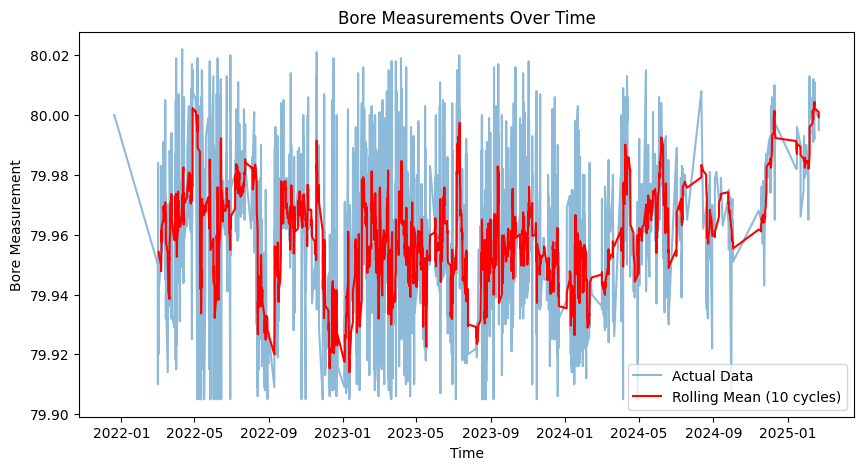

Linear Regression R² Score: 0.0018
No strong trend detected, indicating a non-linear pattern. Random Forest is justified.


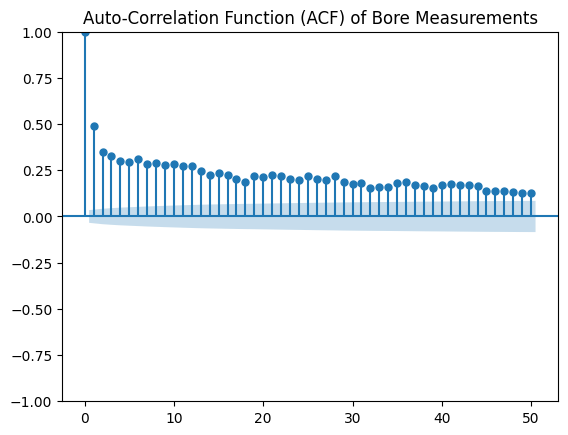

In [7]:
"""Exploratory analysis to check for trends and justify model choice."""

# Sort timestamps and create a numerical index
df = df.sort_values(by="C.[EntryTimestamp]").reset_index(drop=True)
df["Time_Index"] = np.arange(len(df))

# Time Series Plot
plt.figure(figsize=(10, 5))
plt.plot(
    df["C.[EntryTimestamp]"], df["C.[DataValue]"],
    alpha=0.5, label="Actual Data"
)
plt.plot(
    df["C.[EntryTimestamp]"],
    df["C.[DataValue]"].rolling(window=10).mean(),
    color="red", label="Rolling Mean (10 cycles)"
)
plt.xlabel("Time")
plt.ylabel("Bore Measurement")
plt.title("Bore Measurements Over Time")
plt.legend()
plt.show()

# Linear Trend Check
X = df[["Time_Index"]]
y = df["C.[DataValue]"]

lin_reg = LinearRegression().fit(X, y)
linear_r2 = lin_reg.score(X, y)

print(f"Linear Regression R² Score: {linear_r2:.4f}")

if linear_r2 < 0.5:
    print(
        "No strong trend detected, indicating a non-linear pattern. "
        "Random Forest is justified."
    )

# Autocorrelation Plot
plot_acf(df["C.[DataValue]"], lags=50)
plt.title("Auto-Correlation Function (ACF) of Bore Measurements")
plt.show()



#### Interpretation
**Time Series Plot**  
- The actual bore measurements (blue) exhibit significant fluctuations over time.
- The rolling mean (red) smooths variations and provides a clearer picture of trends.
- There is no strong upward or downward trend, suggesting that changes in bore size do not follow a strict pattern over time.

**Linear Trend Analysis**  
- The Linear Regression R² Score is 0.0018, indicating that a linear model would not effectively capture variations in bore size.
- Since no strong trend is detected, using a Random Forest model—which can capture complex patterns—is justified.

**Autocorrelation Analysis (ACF Plot)**  
- The ACF plot shows that past bore measurements influence future values, but the correlation gradually declines over time.
- This suggests that lagged features (previous bore measurements) will be important predictors in our model.


### Section 5: Feature Engineering  

Feature engineering is a critical step in the modeling process, as it transforms raw data into meaningful inputs that enhance predictive accuracy. Given that bore measurements exhibit non-linear patterns and temporal dependencies,  a set of time-series features in engineered to capture these relationships effectively.  


#### Key Features Created:
1. **Lag Features**:  
   - Capture the influence of past measurements on future bore sizes.  
   - Includes lagged values at 3, 5, 10, 15, and 20 cycles to account for short- and long-term dependencies.  

2. **Differencing Features**:  
   - Measure the rate of change in bore size to highlight anomalies.  
   - Differences calculated at 1, 3, 5, and 10-cycle intervals.  

3. **Rolling Statistics**:  
   - Compute rolling means and standard deviations to detect gradual trends and fluctuations.  
   - Calculated over 3, 5, and 10-cycle windows to balance local and broader trends.  

4. **Distance to Tolerance Limits**:  
   - Measures how close bore measurements are to predefined minimum and maximum limits.

5. **Splitting Data for Model Training**:  
   - The dataset is divided into 80% training and 20% testing to evaluate model performance.  
   - Ensures the model learns patterns from historical data while being validated on unseen data.


In [5]:
"""Feature Engineering: Create lag features, rolling statistics, and 
differencing features for Random Forest modeling."""

# Create Lag Features (past values)
lag_values = [3, 5, 10, 15, 20]
for lag in lag_values:
    df[f"DataValue_Lag{lag}"] = df["C.[DataValue]"].shift(lag)

# Create Differencing Features (rate of change)
df["Diff_Lag1"] = df["C.[DataValue]"].diff(1)
df["Diff_Lag3"] = df["C.[DataValue]"] - df["DataValue_Lag3"]
df["Diff_Lag5"] = df["C.[DataValue]"] - df["DataValue_Lag5"]
df["Diff_Lag10"] = df["C.[DataValue]"] - df["DataValue_Lag10"]

# Create Rolling Statistics (trend-based features)
rolling_windows = [3, 5, 10]
for window in rolling_windows:
    df[f"Rolling_Mean_{window}"] = df["C.[DataValue]"].rolling(
        window=window
    ).mean()
    df[f"Rolling_Std_{window}"] = df["C.[DataValue]"].rolling(
        window=window
    ).std()

# Distance to Tolerance Limits
df["Distance_to_MinValue"] = df["C.[DataValue]"] - df["C.[MinValue]"]
df["Distance_to_MaxValue"] = df["C.[MaxValue]"] - df["C.[DataValue]"]

# Define Target Variable
df["Target_NextCycle"] = df["C.[DataValue]"].shift(-1)

# Drop NaN values (from lagging and rolling features)
df = df.dropna().reset_index(drop=True)

# Define Feature List for Random Forest Regressor
rfr_features = [
    "C.[DataValue]", "DataValue_Lag3", "DataValue_Lag5",
    "DataValue_Lag10", "DataValue_Lag15", "DataValue_Lag20",
    "Diff_Lag1", "Diff_Lag3", "Diff_Lag5", "Diff_Lag10",
    "Rolling_Mean_3", "Rolling_Std_3", "Rolling_Mean_5",
    "Rolling_Std_5", "Rolling_Mean_10", "Rolling_Std_10",
    "Distance_to_MinValue", "Distance_to_MaxValue"
]

# Split Data into Training and Test Sets
train_size = int(0.8 * len(df))
X_train, X_test = df[rfr_features][:train_size], df[rfr_features][train_size:]
y_train, y_test = df["Target_NextCycle"][:train_size], df["Target_NextCycle"][train_size:]

### Section 6: Model Training  

After defining the feature set, a Random Forest Regressor (RFR) is trained to predict bore measurements for future cycles. The RFR model is an ensemble learning algorithm that leverages multiple decision trees to improve prediction accuracy while reducing overfitting.  


#### Model Hyperparameters:
- **n_estimators = 200** → Uses 200 decision trees for robust predictions.  
- **max_depth = 10** → Limits tree depth to avoid overfitting.  
- **min_samples_split = 10** → Requires at least 10 samples to split a node.  
- **min_samples_leaf = 5** → Ensures each leaf node has a minimum of 5 samples.  
- **max_features = "sqrt"** → Uses a subset of features at each split for diversity.  
- **bootstrap = True** → Applies bootstrapping for randomness and improved generalization. 

In [6]:
"""Train a Random Forest Regressor with optimized hyperparameters."""

# Define Random Forest Regressor
rfr_model = RandomForestRegressor(
    n_estimators=200,        # Number of trees in the forest
    max_depth=10,            # Maximum depth of each tree
    min_samples_split=10,    # Minimum samples to split a node
    min_samples_leaf=5,      # Minimum samples required in a leaf node
    max_features="sqrt",     # Use a subset of features for each split
    bootstrap=True,          # Bootstrapping for randomness
    random_state=42          # Ensures reproducibility
)

# Train the model
rfr_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=10, n_estimators=200, random_state=42)

### Section 7: Model Evaluation  

To assess the performance and reliability of the trained Random Forest Regressor, an evaluation of its predictive accuracy is done using multiple statistical metrics.  



Random Forest Model Evaluation:
Mean Absolute Error (MAE): 0.0125
Mean Squared Error (MSE): 0.0003
Root Mean Squared Error (RMSE): 0.0166
R² Score: 0.4222


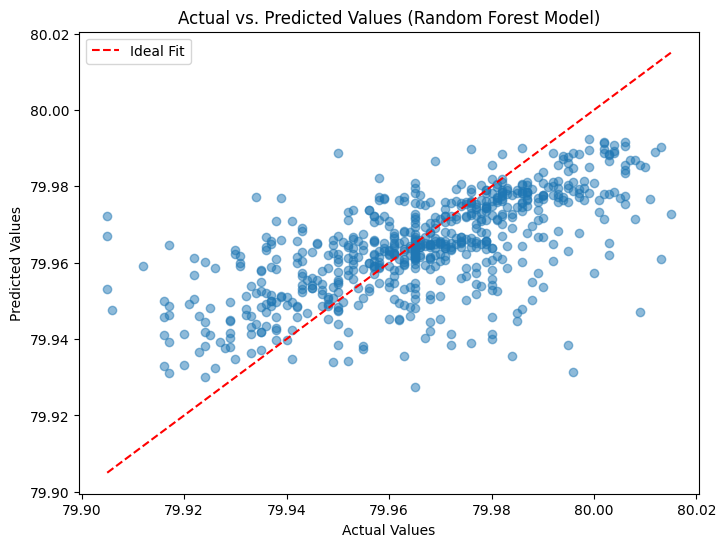

In [7]:
"""Evaluate the performance of the trained Random Forest Regressor."""

# Make Predictions
y_pred = rfr_model.predict(X_test)

# Calculate Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print Evaluation Results
print("\nRandom Forest Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot Actual vs. Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot(
    [y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
    "--", color="red", label="Ideal Fit"
)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (Random Forest Model)")
plt.legend()
plt.show()

#### Evaluation Metrics:
- **Mean Absolute Error (MAE) = 0.0125**  
  - The average absolute difference between actual and predicted bore measurements.
- **Mean Squared Error (MSE) = 0.0003**  
  - A quadratic measure of error, penalizing larger deviations more significantly.
- **Root Mean Squared Error (RMSE) = 0.0166**  
  - The standard deviation of prediction errors, providing an intuitive scale for error magnitude.
- **R² Score = 0.4222**  
  - Represents the proportion of variance explained by the model. While 42.2% of the variability in bore measurements is captured, further optimization may improve performance.

#### Interpretation of Results:
- **Moderate Predictive Performance**: The R² score of 0.4222 suggests that the model captures key trends in the data, though room for improvement exists. In real-world manufacturing and machining processes, achieving perfect predictive accuracy is rare due to factors like sensor noise, material inconsistencies, and environmental fluctuations. Given these practical constraints, this level of predictive power is reasonable for real-world applications.
- **Error Magnitude is Low**: The RMSE of 0.0166 indicates that predictions are close to actual values, with minor deviations.
- **Potential for Further Tuning**: Enhancing feature selection, hyperparameter tuning, or integrating additional temporal patterns could boost accuracy.

#### Visual Analysis:
The scatter plot compares actual vs. predicted values:
- A tight cluster around the red dashed line (ideal fit) indicates reasonable model alignment.

### Section 8: Generate Future Bore Size Predictions  

The goal of this section is to forecast future bore sizes using the trained Random Forest model. This is a key component for*predictive maintenance, enabling proactive decision-making on tool wear and replacement.  


#### Future Prediction Logic:
1. **Cycle Count**: You can define how many future cycles to predict. This is controlled by the `future_cycles` parameter. For example, setting `future_cycles = 10` will predict the next 10 cycles.  
2. **Initial Conditions**: The predictions start from the last known values in the dataset, which are used as the starting point for the future predictions.  
3. **Lag and Rolling Statistics**: The lag values (e.g., 3, 5, 10, 15, 20) and rolling window statistics (e.g., 3, 5, 10) are dynamically updated as new cycles are predicted. These parameters can be adjusted based on the specific patterns and characteristics of your dataset.
4. **Prediction**: The trained Random Forest model predicts bore size for each future cycle based on the updated features, including lag values and rolling statistics.
5. **Wear Classification**: The bore size change for each cycle is classified into one of three categories:
    - **Normal Wear**: Minor changes in bore size.
    - **Moderate Wear**: Significant, but manageable changes.
    - **Critical Wear**: Major changes that might indicate the need for tool maintenance or replacement.


#### Adjustable Parameters:
- **Future Cycles to Predict**: The number of cycles to forecast can be adjusted using the `future_cycles` variable. For example, setting `future_cycles = 10` will forecast the next 10 cycles, but this can be increased or decreased based on the needs of the analysis.
- **Wear Classification Cutoffs**: The thresholds for wear classification can be adjusted within the `classify_wear()` function. For example:
    - Normal wear: `change < 0.001`
    - Moderate wear: `0.001 <= change < 0.005`
    - Critical wear: `change >= 0.005`

These cutoffs can be fine-tuned to match the specific requirements of the tool's operational environment and wear characteristics.

In [8]:
"""Generate future bore size predictions using the trained Random Forest model."""

# Define how many future cycles to predict
future_cycles = 10  # Adjust as needed

# Ensure Cycle_Count exists in the dataset
df["Cycle_Count"] = np.arange(1, len(df) + 1)  # Assigns a unique cycle count

# Create a DataFrame for future predictions
future_df = pd.DataFrame()
future_df["Cycle_Count"] = range(
    df["Cycle_Count"].max() + 1, df["Cycle_Count"].max() + 1 + future_cycles
)

# Use the last known values as the starting point for predictions
last_known_values = df.iloc[-1][rfr_features].to_dict()
predicted_bores = []

# Predict future bore sizes using the trained Random Forest model
for cycle in future_df["Cycle_Count"]:
    new_row = last_known_values.copy()

    # Shift lag values forward
    for lag in [3, 5, 10, 15, 20]:
        new_row[f"DataValue_Lag{lag}"] = (
            predicted_bores[-lag] if len(predicted_bores) >= lag
            else last_known_values["C.[DataValue]"]
        )

    # Update rolling statistics dynamically
    for window in [3, 5, 10]:
        new_row[f"Rolling_Mean_{window}"] = (
            np.mean(predicted_bores[-window:])
            if len(predicted_bores) >= window
            else last_known_values[f"Rolling_Mean_{window}"]
        )
        new_row[f"Rolling_Std_{window}"] = (
            np.std(predicted_bores[-window:])
            if len(predicted_bores) >= window
            else last_known_values[f"Rolling_Std_{window}"]
        )

    # Convert to DataFrame and predict bore size using Random Forest
    new_X = pd.DataFrame([new_row])[rfr_features]
    predicted_bore = rfr_model.predict(new_X)[0]
    predicted_bores.append(predicted_bore)

    # Store predicted values in the DataFrame
    future_df.loc[future_df["Cycle_Count"] == cycle, "Predicted_Bore_Size"] = (
        predicted_bore
    )

# Compute bore size changes over time
future_df["Bore_Size_Change"] = future_df["Predicted_Bore_Size"].diff().fillna(0)

# Define wear classification function (Adjust as needed)
def classify_wear(change):
    """Classify wear stages based on bore size change."""
    if change < 0.001:
        return "Normal Wear"
    elif 0.001 <= change < 0.005:
        return "Moderate Wear"
    return "Critical Wear"

# Assign wear labels to future cycles
future_df["Predicted_Wear_Stage"] = future_df["Bore_Size_Change"].apply(
    classify_wear
)

### Section 9: Prepare and Save the Final Dataset  

This section outlines the process for combining the actual and predicted data to create a final dataset. This dataset includes both the original bore measurements and the model's predictions for future bore sizes along with the corresponding wear stages. The final dataset is then saved in an Excel file for further analysis or integration with tools like Power BI.

#### Final Dataset Preparation:
1. **Actual Data Columns**: The columns for predicted bore sizes and wear stages are set to `NaN` for the actual data, as no predictions are available for those values. This is accomplished by initializing these columns (`"Predicted_Bore_Size"` and `"Predicted_Wear_Stage"`) to `NaN`.
2. **Cycle Count**: A `Cycle_Count` column is created to uniquely identify each cycle in the dataset. This ensures clear tracking of both actual and predicted data.
3. **Concatenation**: The actual dataset (`df`) is concatenated with the predicted data (`future_df`), resulting in the final dataset, stored in the `final_df` DataFrame.
4. **Saving Output**: The `final_df` dataset is saved as an Excel file at the specified file path, making it accessible for further analysis, reporting, or integration with other tools.


In [9]:
"""Prepare and save the final dataset by merging actual and predicted values."""

# Ensure actual data has necessary columns before merging
df["Predicted_Bore_Size"] = np.nan  # Set actual cycles to NaN in prediction column
df["Predicted_Wear_Stage"] = np.nan

# Ensure Cycle_Count exists in the actual dataset
df["Cycle_Count"] = np.arange(1, len(df) + 1)

# Concatenate actual and predicted data
final_df = pd.concat([df, future_df], ignore_index=True)

# Define output file path
output_path = (
    r"G:\College\University of Montana\Semester 4\Capstone"
    r"\MSBA-Capstone-Riley-ORorke\data\rfr_future_wear_predictions.xlsx"
)

# Save the final dataset to an Excel file
final_df.to_excel(output_path, index=False, engine="openpyxl")

# Display the final dataset
final_df



,D.[AssemblyName],C.[EntryTimestamp],C.[DataValue],C.[MinValue],C.[MaxValue],Time_Index,DataValue_Lag3,DataValue_Lag5,DataValue_Lag10,DataValue_Lag15,...,Rolling_Std_5,Rolling_Mean_10,Rolling_Std_10,Distance_to_MinValue,Distance_to_MaxValue,Target_NextCycle,Cycle_Count,Predicted_Bore_Size,Predicted_Wear_Stage,Bore_Size_Change
0,D0445162,2022-03-11 06:12:44.980,79.972,79.905,80.025,23.0,79.963,79.954,79.952,79.984,...,0.007701,79.9672,0.010706,0.067,0.053,79.991,1,NaN,NaN,NaN
1,D0445181,2022-03-11 07:26:11.013,79.991,79.905,80.025,24.0,79.954,79.973,79.983,79.984,...,0.013874,79.9680,0.012211,0.086,0.034,79.971,2,NaN,NaN,NaN
2,D0445177,2022-03-11 08:35:11.610,79.971,79.905,80.025,25.0,79.965,79.963,79.957,79.945,...,0.013465,79.9694,0.011597,0.066,0.054,79.959,3,NaN,NaN,NaN
3,D0445082,2022-03-12 08:40:19.033,79.959,79.905,80.025,26.0,79.972,79.954,79.983,79.920,...,0.012033,79.9670,0.010934,0.054,0.066,79.977,4,NaN,NaN,NaN
4,D0445018,2022-03-12 09:57:02.890,79.977,79.905,80.025,27.0,79.991,79.965,79.968,79.940,...,0.011576,79.9679,0.011387,0.072,0.048,79.971,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3232,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3233,79.983706,Normal Wear,-0.000962
3233,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3234,79.983643,Normal Wear,-0.000063
3234,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3235,79.983643,Normal Wear,0.000000
3235,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3236,79.983686,Normal Wear,0.000044
